# Simple web scraping

This quickstart will show how to get data from HTML pages using the Beautiful Soup library, the state of the art in web scraping (in 2022 at least). First we'll show how to get the HTML content from a web page and then, how to get data scattered through this content. Finally, we'll iterate through several pages in order to get a full dataset from multiple web pages.

Fasten your seatbelts!


In [2]:
import requests

import pandas as pd
from bs4 import BeautifulSoup

### Getting the raw HTML
The following code uses the `requests` library to get the HTML content from the web page. The library makes a GET HTTP request to the web page provided and fetches the response. To know more about search for HTTP requests on Google. 

The cell output is part of the page's HTML code.

In [109]:
BASE_URL = "https://quotes.toscrape.com"

response = requests.get(BASE_URL)
assert response.status_code == 200


response.text[:400]

'<!DOCTYPE html>\n<html lang="en">\n<head>\n\t<meta charset="UTF-8">\n\t<title>Quotes to Scrape</title>\n    <link rel="stylesheet" href="/static/bootstrap.min.css">\n    <link rel="stylesheet" href="/static/main.css">\n</head>\n<body>\n    <div class="container">\n        <div class="row header-box">\n            <div class="col-md-8">\n                <h1>\n                    <a href="/" style="text-decoration'

### Navigating the "Beautiful Soup"
Once we have the raw HTML code, we can use the `Beautiful Soup` library to process it. The `BeautifulSoup(response.text)` returns an object that enables us to navigate the hierarquical structure of the document and gather the required data.

In [116]:
soup = BeautifulSoup(response.text)


def get_soup_from_url(url):
    response = requests.get(url)
    assert response.status_code == 200
    return BeautifulSoup(response.text)

# soup.html.body.div
# itemtype="http://schema.org/CreativeWork"

By looking at the page we see that the data is concentrated in cards. To get this data we have to figure out what does these cards correspond in the HTML.

We can achieve this on Google Chrome by clicking in the card and selecting the `Inspect` option on the dropdown. The developer utilities popup will be shown as it is on the figure below.

Now we can see that the cards correspond to the following HTML tag:

    <div class="quote" itemscope itemtype="http://schema.org/CreativeWork"> ... </div>

By knowing that we can use the Beautiful Soup `findAll()` function in order to acces this data.

<div>
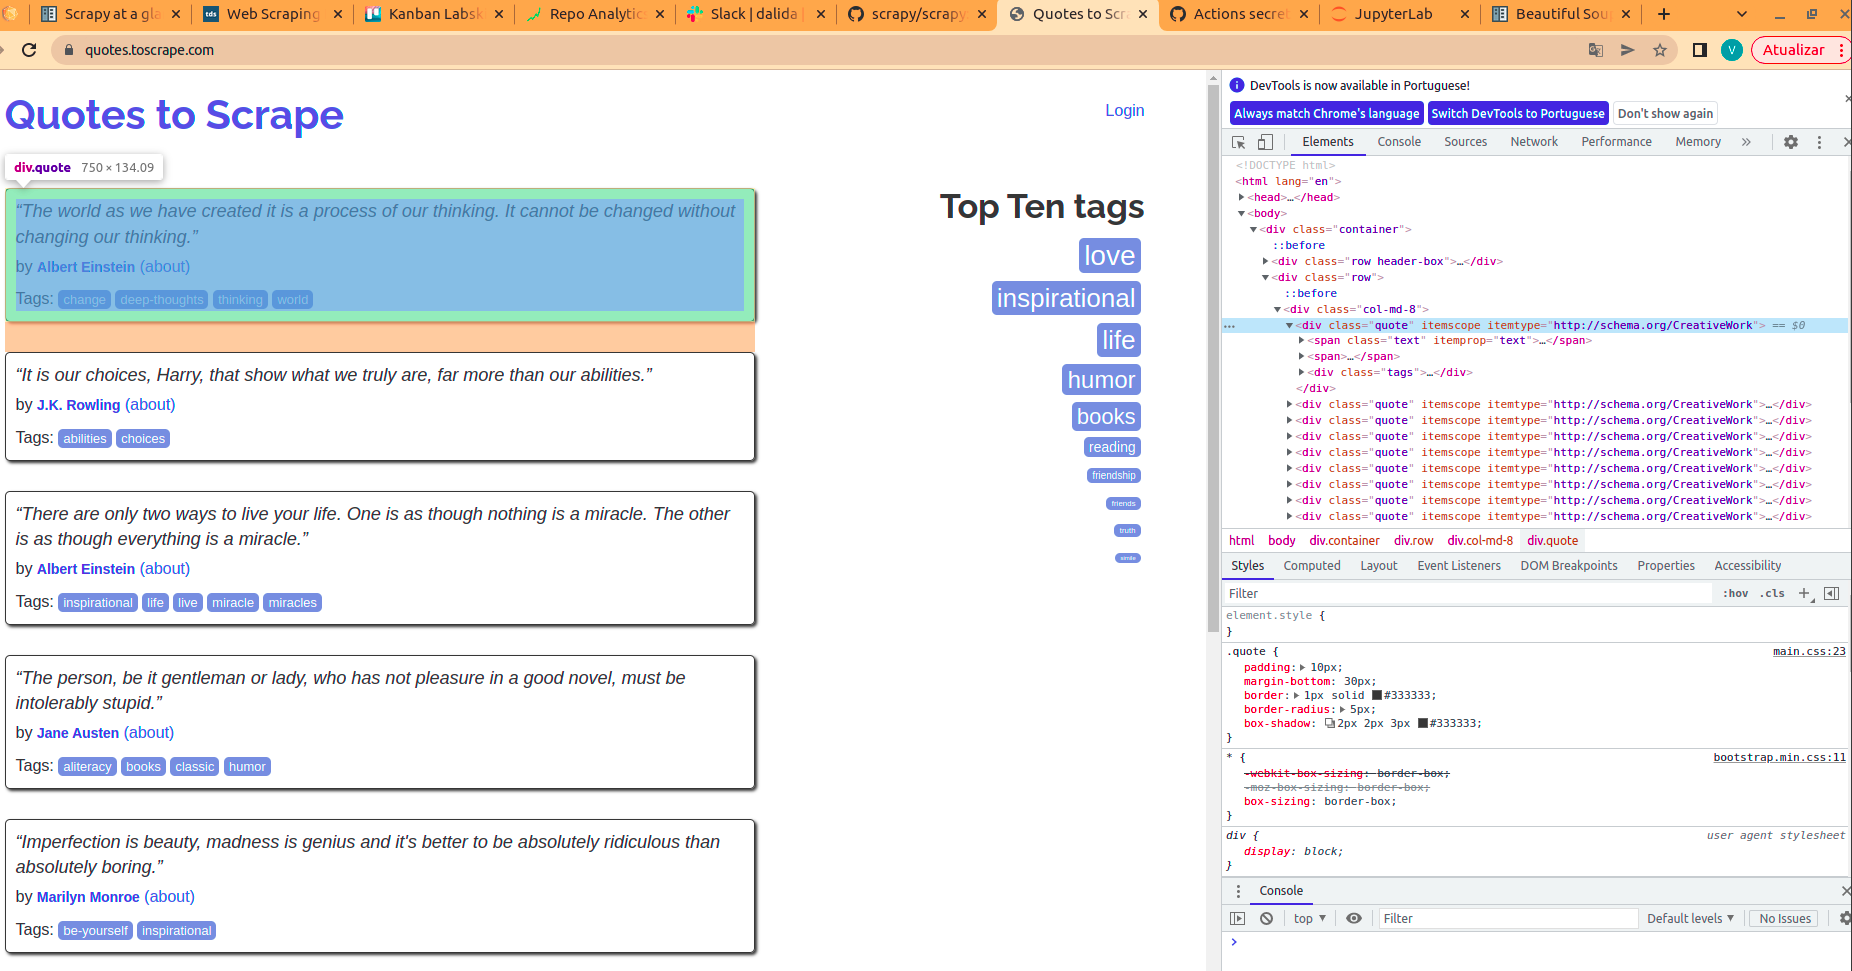
</div>


In [20]:
help(soup.findAll)

Help on method find_all in module bs4.element:

find_all(name=None, attrs={}, recursive=True, text=None, limit=None, **kwargs) method of bs4.BeautifulSoup instance
    Look in the children of this PageElement and find all
    PageElements that match the given criteria.
    
    All find_* methods take a common set of arguments. See the online
    documentation for detailed explanations.
    
    :param name: A filter on tag name.
    :param attrs: A dictionary of filters on attribute values.
    :param recursive: If this is True, find_all() will perform a
        recursive search of this PageElement's children. Otherwise,
        only the direct children will be considered.
    :param limit: Stop looking after finding this many results.
    :kwargs: A dictionary of filters on attribute values.
    :return: A ResultSet of PageElements.
    :rtype: bs4.element.ResultSet



In the following code we search for all the `<div>` tags that have the `class="quote"` attribute. 

In [88]:
def get_quote_cards(document):
    return document.findAll('div', attrs={"class": "quote"})


quote_cards = get_quote_cards(soup)

In [89]:
quote_cards[0]

<div class="quote" itemscope="" itemtype="http://schema.org/CreativeWork">
<span class="text" itemprop="text">“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”</span>
<span>by <small class="author" itemprop="author">Albert Einstein</small>
<a href="/author/Albert-Einstein">(about)</a>
</span>
<div class="tags">
            Tags:
            <meta class="keywords" content="change,deep-thoughts,thinking,world" itemprop="keywords"/>
<a class="tag" href="/tag/change/page/1/">change</a>
<a class="tag" href="/tag/deep-thoughts/page/1/">deep-thoughts</a>
<a class="tag" href="/tag/thinking/page/1/">thinking</a>
<a class="tag" href="/tag/world/page/1/">world</a>
</div>
</div>

Inside each of these "quote cards" we can get all the data we want by applying the same observations.

The quote text is inside the `<span>` tag, that has the attribute `class="text"`.
The author name is inside the `<small>` tag, that has the attribute `class="author"`.

The quote tags are `<a>` tags, that has the attribute `class="tag"`. As we have more than one tag, we have to iterate the array in order to have the full list of values.

In [82]:
def get_quote(card):
    return card.findAll(name="span", attrs={"class": "text"})[0].get_text()


def get_author(card):
    return card.findAll(name="small", attrs={"class": "author"})[0].get_text()


def get_tags(card):
    tags = card.findAll('a', attrs={"class": "tag"})
    return [
        t.get_text()
        for t in tags
    ]

quote = get_quote(quote_cards[0])
author = get_author(quote_cards[0])
tags = get_tags(quote_cards[0])

In [83]:
author, quote, tags

('Albert Einstein',
 '“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”',
 ['change', 'deep-thoughts', 'thinking', 'world'])

With the functions created in the previous cell we can create a loop to fetch all quotes from a page and structure this as a DataFrame.

In [87]:

def get_cards_data(quote_cards):
    quotes_list = []

    for card in quote_cards:
        quote = get_quote(card)
        author = get_author(card)
        tags = get_tags(card)

        quotes_list.append(dict(
            quote=quote,
            author=author,
            tags=tags
        ))

    return pd.DataFrame(quotes_list)

data = get_cards_data(quote_cards)
data

,quote,author,tags
0,“The world as we have created it is a process ...,Albert Einstein,"[change, deep-thoughts, thinking, world]"
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling,"[abilities, choices]"
2,“There are only two ways to live your life. On...,Albert Einstein,"[inspirational, life, live, miracle, miracles]"
3,"“The person, be it gentleman or lady, who has ...",Jane Austen,"[aliteracy, books, classic, humor]"
4,"“Imperfection is beauty, madness is genius and...",Marilyn Monroe,"[be-yourself, inspirational]"
5,“Try not to become a man of success. Rather be...,Albert Einstein,"[adulthood, success, value]"
6,“It is better to be hated for what you are tha...,André Gide,"[life, love]"
7,"“I have not failed. I've just found 10,000 way...",Thomas A. Edison,"[edison, failure, inspirational, paraphrased]"
8,“A woman is like a tea bag; you never know how...,Eleanor Roosevelt,[misattributed-eleanor-roosevelt]
9,"“A day without sunshine is like, you know, nig...",Steve Martin,"[humor, obvious, simile]"


### Pagination

One final step from this web scrapping is to take the data from all the pages in the website. To achieve this we will iteractivelly go forward and back using the website navigations.


From inspection we see that the URL for the is inside a `<a>` tag, nested in the `<li class="next">` tag. 

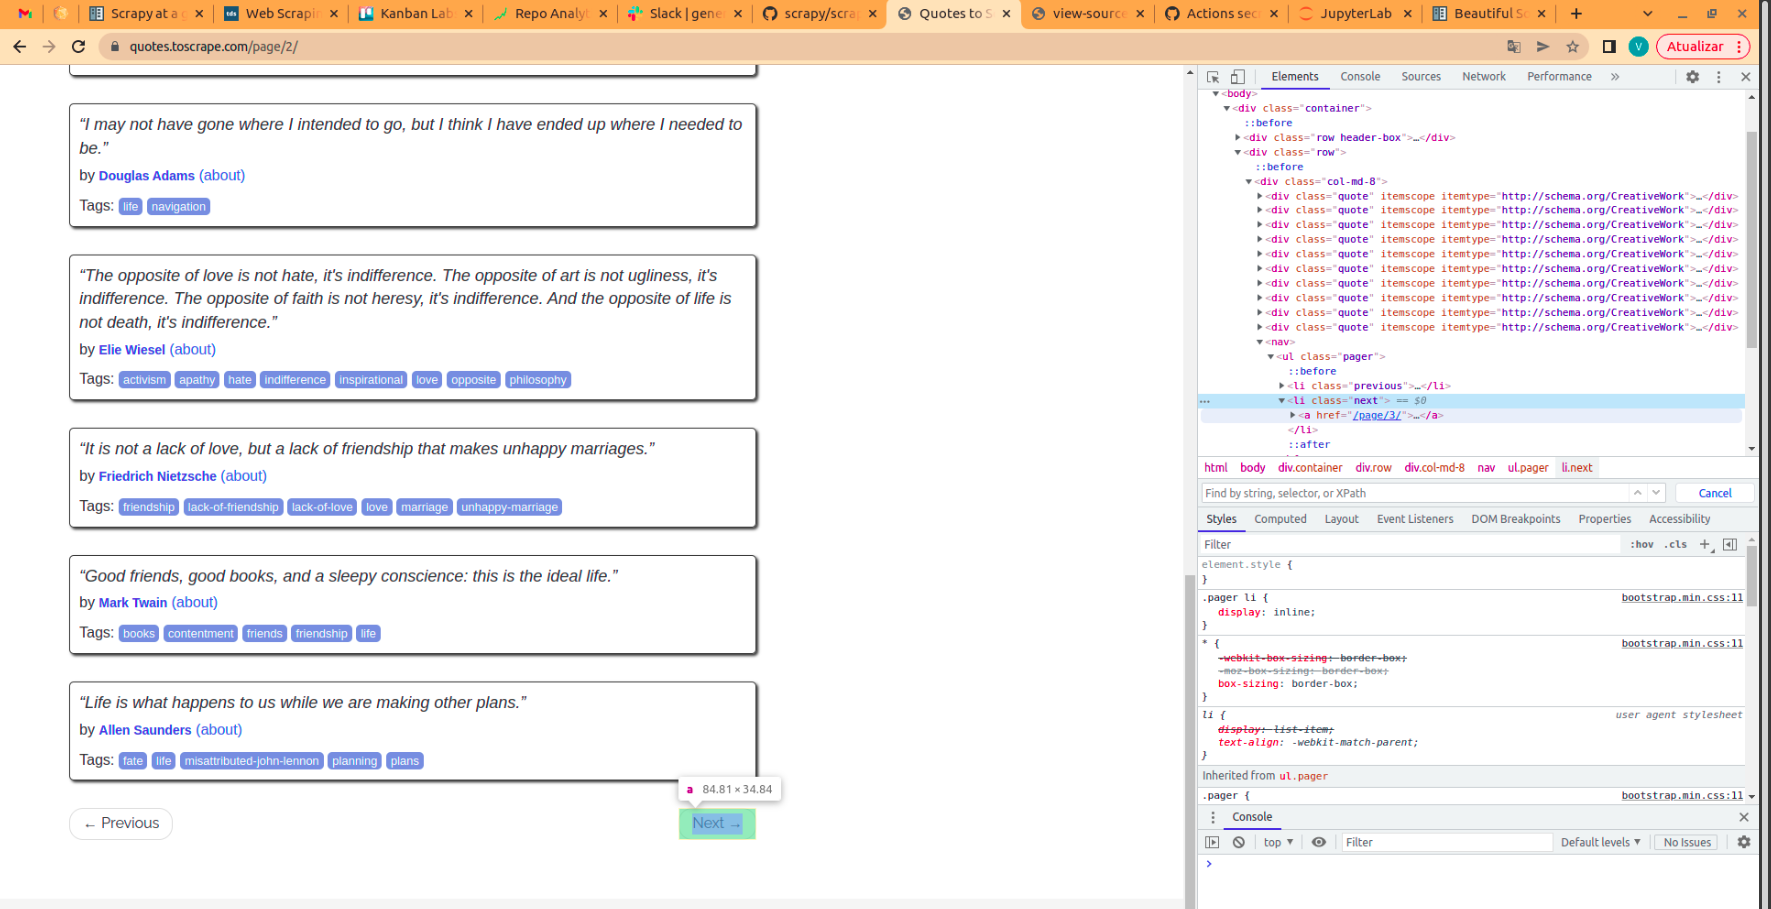


In [111]:
def get_next_url(document):
    nav_tag = document.find('nav').find('li', attrs={'class': 'next'})
    
    # if there isn't a nav tag, there is no next URL
    if nav_tag is None:
        return None
    
    nav_tag.find('a')
    return nav_tag.find('a').get('href')


get_next_url(soup)

'/page/2/'

Wrapping it all

In [117]:
BASE_URL = next_url = "https://quotes.toscrape.com"

full_data = []

while 1:
    print(f"Getting data from {next_url}")
    
    # get raw html from web
    soup = get_soup_from_url(next_url)

    # get data from page
    quote_cards = get_quote_cards(soup)
    data = get_cards_data(quote_cards)
    
    full_data.append(data)
    
    # paginate to next page
    posfix = get_next_url(soup)
    
    if posfix is None:
        break

    next_url = BASE_URL + get_next_url(soup)
    
    
df = pd.concat(full_data)

Getting data from https://quotes.toscrape.com
Getting data from https://quotes.toscrape.com/page/2/
Getting data from https://quotes.toscrape.com/page/3/
Getting data from https://quotes.toscrape.com/page/4/
Getting data from https://quotes.toscrape.com/page/5/
Getting data from https://quotes.toscrape.com/page/6/
Getting data from https://quotes.toscrape.com/page/7/
Getting data from https://quotes.toscrape.com/page/8/
Getting data from https://quotes.toscrape.com/page/9/
Getting data from https://quotes.toscrape.com/page/10/


In [118]:
df

,quote,author,tags
0,“The world as we have created it is a process ...,Albert Einstein,"[change, deep-thoughts, thinking, world]"
1,"“It is our choices, Harry, that show what we t...",J.K. Rowling,"[abilities, choices]"
2,“There are only two ways to live your life. On...,Albert Einstein,"[inspirational, life, live, miracle, miracles]"
3,"“The person, be it gentleman or lady, who has ...",Jane Austen,"[aliteracy, books, classic, humor]"
4,"“Imperfection is beauty, madness is genius and...",Marilyn Monroe,"[be-yourself, inspirational]"
...,...,...,...
5,“You never really understand a person until yo...,Harper Lee,[better-life-empathy]
6,“You have to write the book that wants to be w...,Madeleine L'Engle,"[books, children, difficult, grown-ups, write,..."
7,“Never tell the truth to people who are not wo...,Mark Twain,[truth]
8,"“A person's a person, no matter how small.”",Dr. Seuss,[inspirational]
